# Digits recognizer. Keras implementation

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization, Conv2D, MaxPool2D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# hyperparams
input_shape = (28, 28, 1)
batch_size = 16
epochs = 4
number_of_classes = 10

In [10]:
class MNISTmodel:
    seed = 42
    epochs = epochs
    batch_size = batch_size
    input_shape = input_shape
    number_of_classes = number_of_classes
    cval_test_size = 0.1
    
    model = None
    
    def __init__(self, train, test):
        if not (isinstance(train, pd.DataFrame) and isinstance(test, pd.DataFrame)):
            train = pd.read_csv(train)
            test = pd.read_csv(test)

        self.preprocessing(train, test)

    
    def preprocessing(self, train, test):
        # only pixels to numpy ndarray
        x_train = train.iloc[:, 1:].values.astype('float32')
        x_test  = test.values.astype('float32')

        # train labels for X_train
        y_train = train.iloc[:, 0].values.astype('float32')
        y_train = self.onehot_encode(y_train)

        # normalize pixels => [0..1]
        x_train = x_train / 255.
        x_test  = x_test  / 255.

        # reshape
        number_of_train = x_train.shape[0]
        number_of_test  = x_test.shape[0]
        
        # assign
        x_train = x_train.reshape(number_of_train, *self.input_shape) # (n, 28, 28, 1)
        self.x_test  = x_test.reshape(number_of_test, *self.input_shape) # (n, 28, 28, 1)
        
        # cross validation
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(x_train, y_train, 
                                                                              test_size=self.cval_test_size,
                                                                              random_state=self.seed)

    def onehot_encode(self, labels):
        return to_categorical(labels, self.number_of_classes)
    
    def build_sequential(self):
        self.model = Sequential()
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=self.input_shape))
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
        self.model.add(MaxPool2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.2))
        self.model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
        self.model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
        self.model.add(MaxPool2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))
        self.model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
        self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.25))
        self.model.add(Dense(self.number_of_classes, activation='softmax'))

    def compile(self):
        self.model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=RMSprop(),
                   metrics=['accuracy'])
        
        self.lerning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                                        patience=3,
                                                        verbose=1,
                                                        factor=0.5,
                                                        min_lr=0.0001)
    
    @staticmethod
    def datagen():
        return ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)
    
    def summary(self):
        self.model.summary()
        
    def evaluate(self, x=None, y=None, verbose=0):
        final_loss, final_acc = None, None
        
        if x is None and y is None:
            x, y = self.x_val, self.y_val
            
        final_loss, final_acc = self.model.evaluate(x, y, verbose=verbose)
        print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))
        
    def predict(self, test=None, classes=False):
        if test is None:
            test = self.x_test

        if classes:
            return self.model.predict_classes(test)
        else:
            return self.model.predict(test)
        
    
    

### Check files

In [11]:
from subprocess import check_output
print(check_output(['ls', './input']).decode('utf8'))

sample_submission.csv
test.csv
train.csv



### Read dataset

In [12]:
train = pd.read_csv('./input/train.csv')
test  = pd.read_csv('./input/test.csv')

In [13]:
mnist = MNISTmodel(train, test)
mnist.build_sequential()
mnist.compile()
mnist.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [14]:
datagen = MNISTmodel.datagen()
datagen.fit(mnist.x_train)

In [15]:
history = mnist.model.fit_generator(datagen.flow(mnist.x_train, mnist.y_train, batch_size=mnist.batch_size),
                                  epochs=mnist.epochs,
                                  verbose=1,
                                  validation_data=(mnist.x_val, mnist.y_val),
                                  steps_per_epoch=mnist.x_train.shape[0] // mnist.batch_size,
                                  callbacks=[mnist.lerning_rate_reduction])

Epoch 1/4
2362/2362 [==============================] - 139s 59ms/step - loss: 0.3103 - acc: 0.9021 - val_loss: 0.0480 - val_acc: 0.9864
Epoch 2/4
2362/2362 [==============================] - 139s 59ms/step - loss: 0.1213 - acc: 0.9628 - val_loss: 0.0451 - val_acc: 0.9867
Epoch 3/4
2362/2362 [==============================] - 125s 53ms/step - loss: 0.0988 - acc: 0.9710 - val_loss: 0.0339 - val_acc: 0.9898
Epoch 4/4
2362/2362 [==============================] - 128s 54ms/step - loss: 0.0894 - acc: 0.9732 - val_loss: 0.0308 - val_acc: 0.9921


In [16]:
mnist.evaluate()

Final loss: 0.030829, final accuracy: 0.992143


In [41]:
y_pred = mnist.predict(mnist.x_test, classes=True)
y_pred

array([2, 0, 9, ..., 3, 9, 2])

In [43]:
len(y_pred)

28000

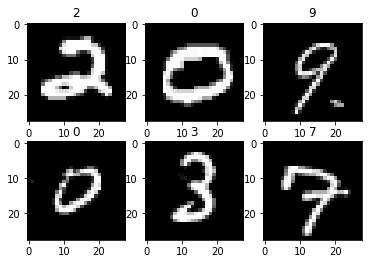

In [42]:
for i in range(0, 6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(mnist.x_test[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.title(y_pred[i]);


In [54]:
df = pd.DataFrame({ 'ImageId': list(range(1, len(y_pred) + 1)), 'Label': y_pred })
df.to_csv('results.csv', sep=',', index=False, index_label='ImageId')